In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


import random
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score


import warnings
import os
import sys


root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from utils.utils import *
from utils.constant import *

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
# Set a seed for reproducibility
np.random.seed(42)


In [2]:
file_path = get_absolute_path(
    'small_set_sales_by_date_sku_zip.csv',
    'data',
    PROJECT_BASE_DIR
)

data = pd.read_csv(file_path)

In [17]:
# Combine 'PRODUCT_CATEGORY_LEVEL1' and 'PRODUCT_CATEGORY_LEVEL3' into a new column
data['SEGMENT'] = data['PRODUCT_CATEGORY_LEVEL1'] + ' - ' + data['PRODUCT_CATEGORY_LEVEL3']


In [18]:
# data = data[data.PRODUCT_MERCH_CLASSIFICATION3 == 'Dry Food']
data.head(3)

,ORDER_PLACED_DTTM,PRODUCT_PART_NUMBER,CUSTOMER_ADDRESS_ZIP,PRODUCT_CATEGORY_LEVEL1,PRODUCT_CATEGORY_LEVEL2,PRODUCT_CATEGORY_LEVEL3,PRODUCT_MERCH_CLASSIFICATION1,PRODUCT_MERCH_CLASSIFICATION2,PRODUCT_MERCH_CLASSIFICATION3,NET_SALES,UNITS,SEGMENT
0,2022-11-22,100112,1028.0,Cat,Food,Dry Food,Consumables,Core Food,Dry Food,0.00,1.0,Cat - Dry Food
1,2022-11-22,100112,2152.0,Cat,Food,Dry Food,Consumables,Core Food,Dry Food,6.47,1.0,Cat - Dry Food
2,2022-11-22,100112,2813.0,Cat,Food,Dry Food,Consumables,Core Food,Dry Food,6.47,1.0,Cat - Dry Food


In [19]:
### Basic Information about the Datasets

# Display basic information about the dataset
print(data.info())

# Display summary statistics for numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7417129 entries, 0 to 7417128
Data columns (total 12 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   ORDER_PLACED_DTTM              object 
 1   PRODUCT_PART_NUMBER            int64  
 2   CUSTOMER_ADDRESS_ZIP           float64
 3   PRODUCT_CATEGORY_LEVEL1        object 
 4   PRODUCT_CATEGORY_LEVEL2        object 
 5   PRODUCT_CATEGORY_LEVEL3        object 
 6   PRODUCT_MERCH_CLASSIFICATION1  object 
 7   PRODUCT_MERCH_CLASSIFICATION2  object 
 8   PRODUCT_MERCH_CLASSIFICATION3  object 
 9   NET_SALES                      float64
 10  UNITS                          float64
 11  SEGMENT                        object 
dtypes: float64(3), int64(1), object(8)
memory usage: 679.1+ MB
None
       PRODUCT_PART_NUMBER  CUSTOMER_ADDRESS_ZIP     NET_SALES         UNITS
count         7.417129e+06          7.410835e+06  7.417128e+06  7.417128e+06
mean          1.469925e+05          4.690795e+04

In [20]:
len(data)

7417129

In [21]:
# Update the original DataFrame after dropping NaNs
data = data.dropna()


In [22]:
len(data)

7410834

In [24]:
print(len(data.SEGMENT.unique()))
data.SEGMENT.unique()

8


array(['Cat - Dry Food', 'Dog - Dry Food',
       'Dog - Flea Combs & Tick Removers', 'Dog - Poop Scoopers',
       'Dog - Test Kits', 'Pharmacy - Medications',
       'Cat - Flea Combs & Tick Removers', 'Cat - Test Kits'],
      dtype=object)

In [25]:
### Basic Information about the Datasets

# Display basic information about the dataset
print(data.info())

# Display summary statistics for numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 7410834 entries, 0 to 7417127
Data columns (total 12 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   ORDER_PLACED_DTTM              object 
 1   PRODUCT_PART_NUMBER            int64  
 2   CUSTOMER_ADDRESS_ZIP           float64
 3   PRODUCT_CATEGORY_LEVEL1        object 
 4   PRODUCT_CATEGORY_LEVEL2        object 
 5   PRODUCT_CATEGORY_LEVEL3        object 
 6   PRODUCT_MERCH_CLASSIFICATION1  object 
 7   PRODUCT_MERCH_CLASSIFICATION2  object 
 8   PRODUCT_MERCH_CLASSIFICATION3  object 
 9   NET_SALES                      float64
 10  UNITS                          float64
 11  SEGMENT                        object 
dtypes: float64(3), int64(1), object(8)
memory usage: 735.0+ MB
None
       PRODUCT_PART_NUMBER  CUSTOMER_ADDRESS_ZIP     NET_SALES         UNITS
count         7.410834e+06          7.410834e+06  7.410834e+06  7.410834e+06
mean          1.469940e+05          4.690795e+04  3.9

# EM Algorithm / Gaussian Mixture Model for Anomaly Detection

3 Major Things to Pay Attention to:

1. Our data contains missing values (NaN), and the GaussianMixture algorithm does not handle missing values natively. To address this issue, we need to handle missing values (I just dropped the `NET_SALES` or `UNITS` records that contains missing values) in our data before fitting the model. 
2. Need to tune hyperparameter `n_components`.
3. Need to decide the `threshold`.

### Given `n_components` and `threshold`

In this section, we assume `n_components = 8` (in this selected data, we have 8 segments), and `threshold = -50`. 


In [26]:
# Select the columns for anomaly detection
columns_for_anomaly_detection = ['NET_SALES', 'UNITS']
data_for_anomaly_detection = data[columns_for_anomaly_detection]

# Check for missing values and handle them (replace NaN with a suitable strategy, e.g., mean)



In [27]:
# Standardize the data
scaler = StandardScaler()
data_for_anomaly_detection_standardized = scaler.fit_transform(data_for_anomaly_detection)



In [28]:
# Choose the number of components (clusters) for the GMM
n_components = 8  # You may need to adjust this based on the characteristics of your data

# Fit a Gaussian Mixture Model to the data
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(data_for_anomaly_detection_standardized)


GaussianMixture(n_components=8, random_state=42)

In [29]:
# Predict the labels (clusters) for each data point
labels = gmm.predict(data_for_anomaly_detection_standardized)

# Add the cluster labels to the original DataFrame
data['cluster_label'] = labels

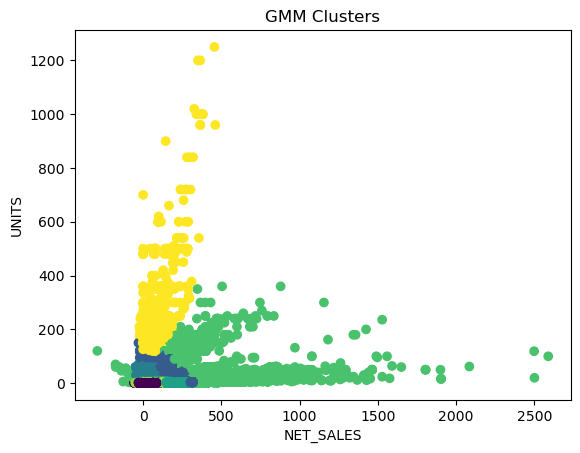

In [30]:
# Visualize the clusters
plt.scatter(data['NET_SALES'], data['UNITS'], c=labels, cmap='viridis')
plt.xlabel('NET_SALES')
plt.ylabel('UNITS')
plt.title('GMM Clusters')
plt.show()


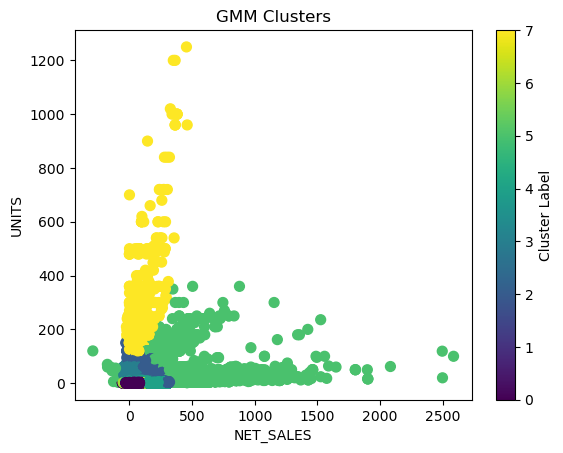

In [31]:
# Visualize the clusters with colorbar, different marker styles, and adjusted marker size
scatter = plt.scatter(data['NET_SALES'], data['UNITS'], c=labels, cmap='viridis', marker='o', s=50)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')

# Customize the plot
plt.xlabel('NET_SALES')
plt.ylabel('UNITS')
plt.title('GMM Clusters')

# Show the plot
plt.show()


In [40]:
# Calculate the likelihood of each data point under the model
likelihoods = gmm.score_samples(data_for_anomaly_detection_standardized)

# Set a threshold for anomaly detection (you may need to adjust this)
threshold = -50  # Example threshold, adjust based on the distribution of likelihoods


In [42]:
# Identify anomalies based on the threshold
anomalies = data[likelihoods < threshold]

# Print or further analyze the anomalies
print(f"Anomalies:{len(anomalies)}")
print(anomalies)

Anomalies:22
        ORDER_PLACED_DTTM  PRODUCT_PART_NUMBER  CUSTOMER_ADDRESS_ZIP  \
3013777        2023-05-05               139306               19711.0   
3197568        2023-02-10               139318               33166.0   
4261210        2023-01-19               146325               30040.0   
4269250        2023-02-09               146536               98230.0   
4278409        2023-11-01               146580               87107.0   
4278743        2023-11-21               146580               34472.0   
4286761        2023-06-12               146645                3461.0   
4295775        2023-03-05               146654               22032.0   
4302954        2022-12-01               146804               13416.0   
4302961        2022-12-08               146804                2816.0   
4303089        2023-04-04               146804                1254.0   
4303112        2023-04-24               146804               21601.0   
4303116        2023-04-28               146804     

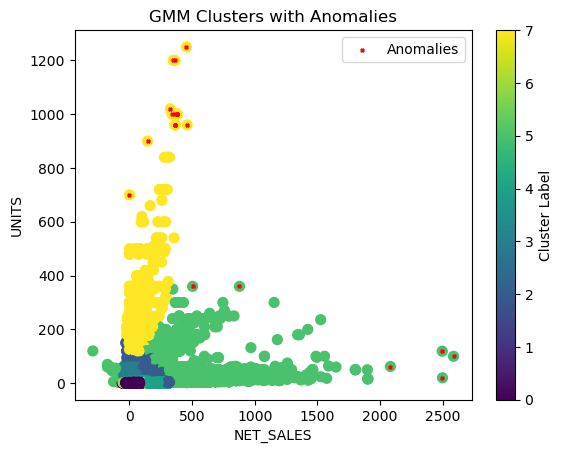

In [44]:
# Visualize the clusters with colorbar, different marker styles, and adjusted marker size
scatter = plt.scatter(data['NET_SALES'], data['UNITS'], c=labels, cmap='viridis', marker='o', s=50)

# Identify anomalies based on the threshold
anomaly_mask = likelihoods < threshold
anomalies = data[anomaly_mask]

# Visualize anomalies with a different color and marker style
plt.scatter(anomalies['NET_SALES'], anomalies['UNITS'], c='red', marker='X', s=5, label='Anomalies')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')

# Customize the plot
plt.xlabel('NET_SALES')
plt.ylabel('UNITS')
plt.title('GMM Clusters with Anomalies')
plt.legend()  # Show legend including the 'Anomalies' label

# Show the plot
plt.show()


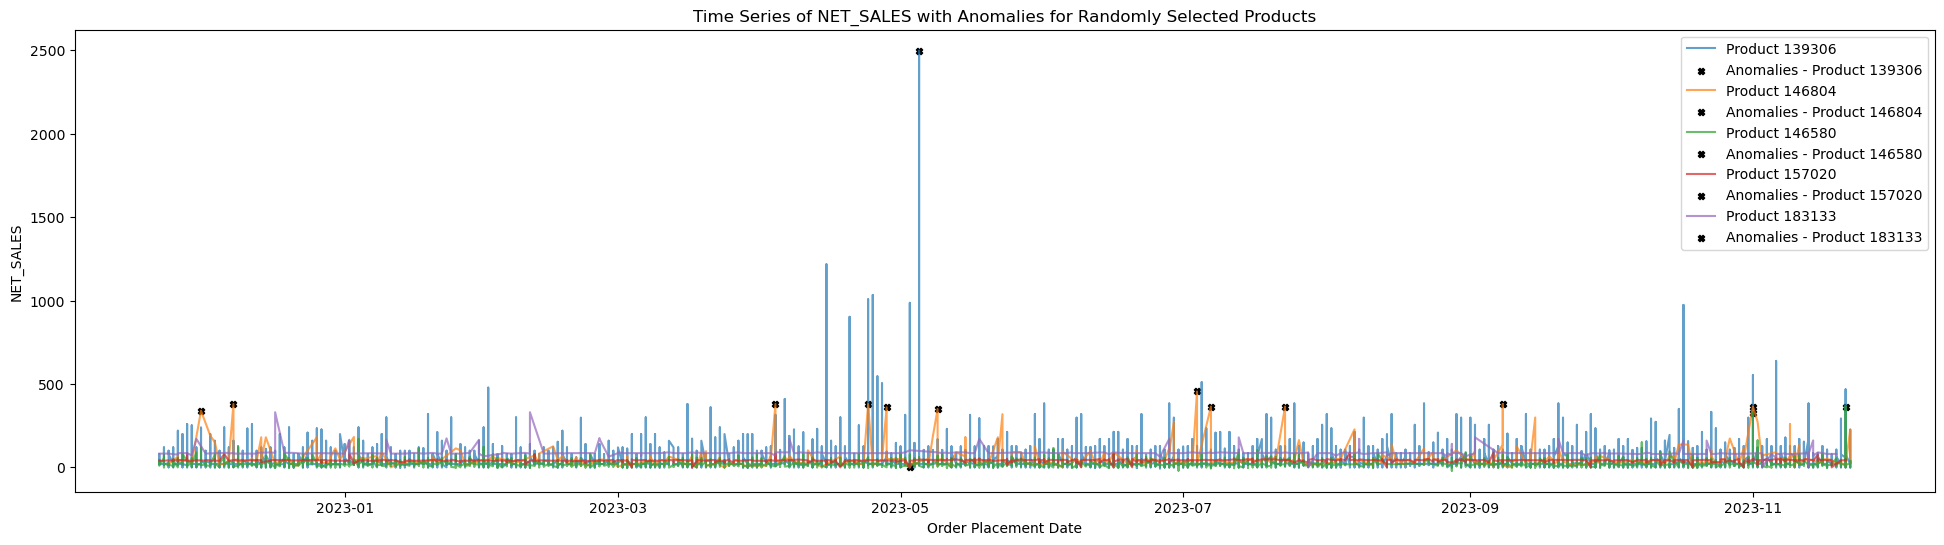

In [51]:


# We have a large number of unique PRODUCT_PART_NUMBER values and the figure becomes overwhelming, we
# can choose to randomly select and visualize a subset of them. 

# Convert 'ORDER_PLACED_DTTM' to datetime if it's not already in datetime format
data['ORDER_PLACED_DTTM'] = pd.to_datetime(data['ORDER_PLACED_DTTM'])

# Identify anomalies based on the threshold
anomaly_mask = likelihoods < threshold
anomalies = data[anomaly_mask]

# Get PRODUCT_PART_NUMBER values with anomalies
product_numbers_with_anomalies = anomalies['PRODUCT_PART_NUMBER'].unique()

# Get PRODUCT_PART_NUMBER values without anomalies
product_numbers_without_anomalies = data['PRODUCT_PART_NUMBER'].unique()
product_numbers_without_anomalies = list(set(product_numbers_without_anomalies) - set(product_numbers_with_anomalies))

# Randomly select a subset of PRODUCT_PART_NUMBER values that includes both cases
random_product_numbers_with_anomalies = random.sample(product_numbers_with_anomalies.tolist(), k=3)
random_product_numbers_without_anomalies = random.sample(product_numbers_without_anomalies, k=2)

random_product_numbers = random_product_numbers_with_anomalies + random_product_numbers_without_anomalies

# Plot time series of NET_SALES for each randomly selected PRODUCT_PART_NUMBER
plt.figure(figsize=(24, 6))

for product_number in random_product_numbers:
    product_data = data[data['PRODUCT_PART_NUMBER'] == product_number]
    product_anomalies = anomalies[anomalies['PRODUCT_PART_NUMBER'] == product_number]

    plt.plot(product_data['ORDER_PLACED_DTTM'], product_data['NET_SALES'], label=f'Product {product_number}', alpha=0.7)

    # Highlight anomalies for each product
    plt.scatter(product_anomalies['ORDER_PLACED_DTTM'], product_anomalies['NET_SALES'],
                c='black', marker='X', s=20, label=f'Anomalies - Product {product_number}')

# Customize the plot
plt.xlabel('Order Placement Date')
plt.ylabel('NET_SALES')
plt.title('Time Series of NET_SALES with Anomalies for Randomly Selected Products')
plt.legend()

# Show the plot
plt.show()

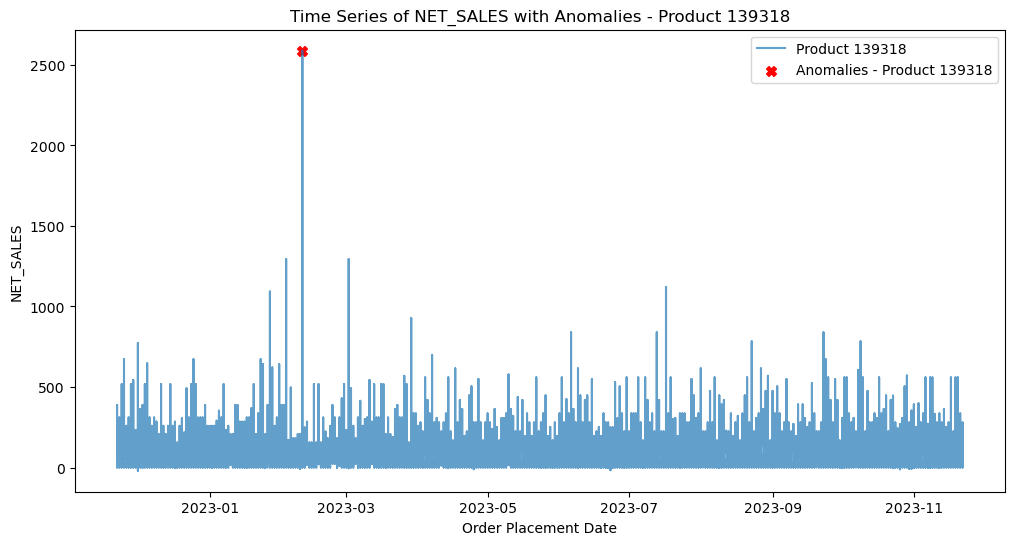

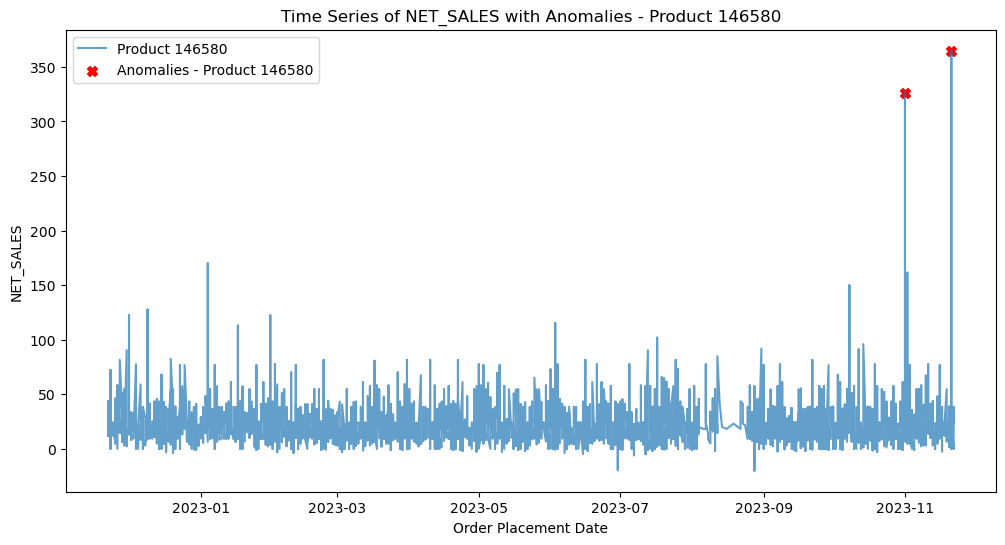

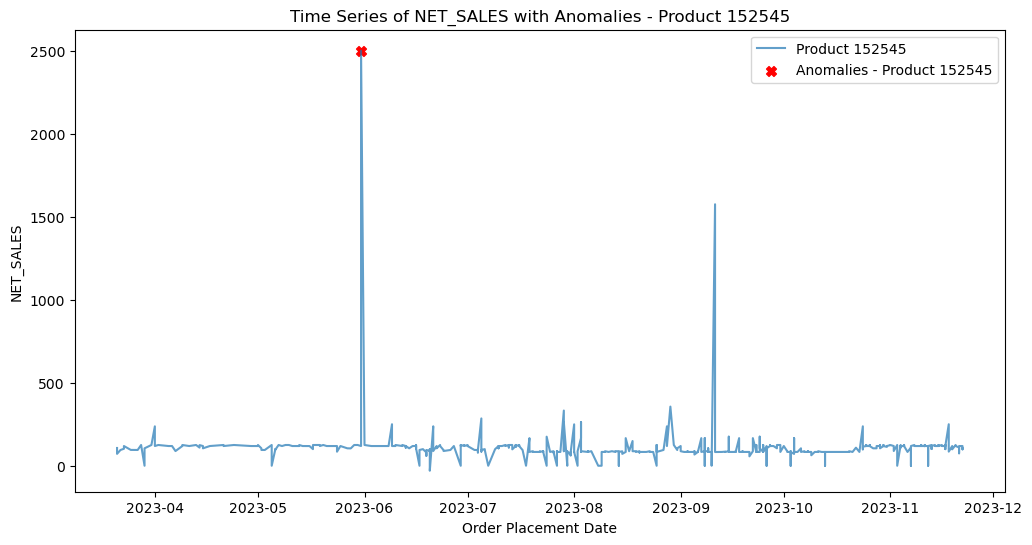

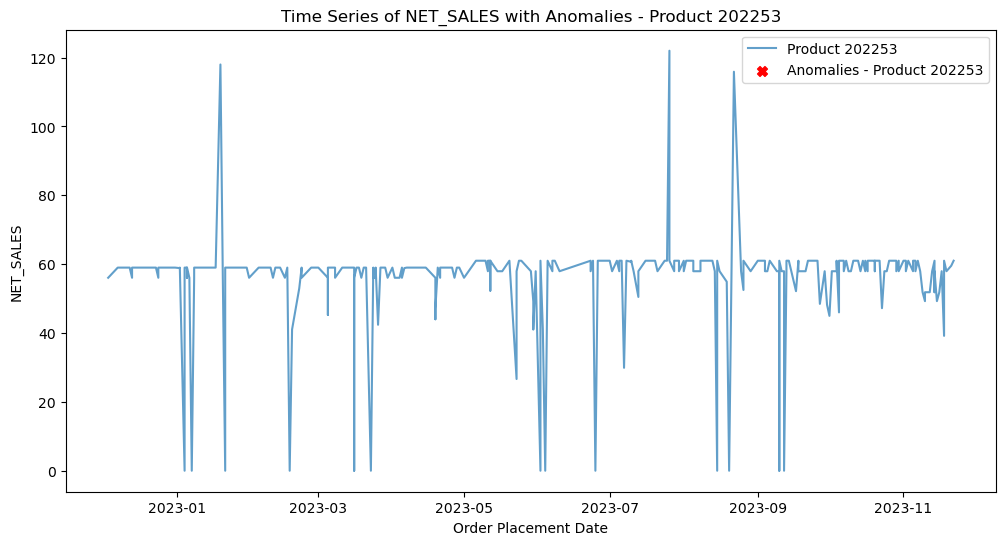

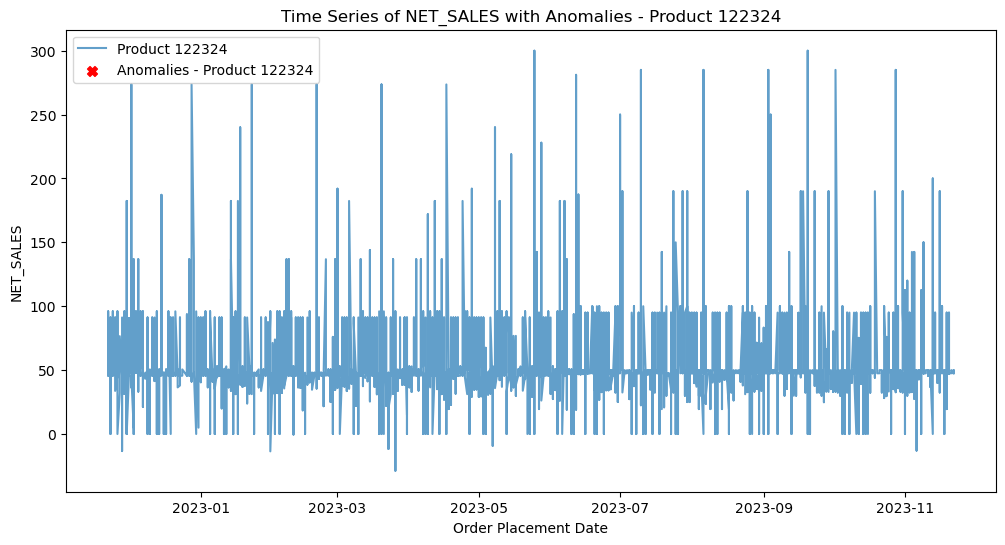

In [57]:
# Convert 'ORDER_PLACED_DTTM' to datetime if it's not already in datetime format
data['ORDER_PLACED_DTTM'] = pd.to_datetime(data['ORDER_PLACED_DTTM'])

# Identify anomalies based on the threshold
anomaly_mask = likelihoods < threshold
anomalies = data[anomaly_mask]

# Get PRODUCT_PART_NUMBER values with anomalies
product_numbers_with_anomalies = anomalies['PRODUCT_PART_NUMBER'].unique()

# Get PRODUCT_PART_NUMBER values without anomalies
product_numbers_without_anomalies = data['PRODUCT_PART_NUMBER'].unique()
product_numbers_without_anomalies = list(set(product_numbers_without_anomalies) - set(product_numbers_with_anomalies))

# Randomly select a subset of PRODUCT_PART_NUMBER values that includes both cases
random_product_numbers_with_anomalies = random.sample(product_numbers_with_anomalies.tolist(), k=3)
random_product_numbers_without_anomalies = random.sample(product_numbers_without_anomalies, k=2)

random_product_numbers = random_product_numbers_with_anomalies + random_product_numbers_without_anomalies

# Plot time series of NET_SALES for each randomly selected PRODUCT_PART_NUMBER
for product_number in random_product_numbers:
    plt.figure(figsize=(12, 6))

    product_data = data[data['PRODUCT_PART_NUMBER'] == product_number]
    product_anomalies = anomalies[anomalies['PRODUCT_PART_NUMBER'] == product_number]

    plt.plot(product_data['ORDER_PLACED_DTTM'], product_data['NET_SALES'], label=f'Product {product_number}', alpha=0.7)

    # Highlight anomalies for each product
    plt.scatter(product_anomalies['ORDER_PLACED_DTTM'], product_anomalies['NET_SALES'],
                c='red', marker='X', s=50, label=f'Anomalies - Product {product_number}')

    # Customize the plot
    plt.xlabel('Order Placement Date')
    plt.ylabel('NET_SALES')
    plt.title(f'Time Series of NET_SALES with Anomalies - Product {product_number}')
    plt.legend()

    # Show the plot
    plt.show()


There is a noticeable spike in the time series data for Product 146324, but it is not labeled as an anomaly, it could be due to several reasons. Let's explore some possibilities:

1. Threshold Selection: The anomaly detection process involves setting a threshold to identify anomalies. If the threshold is too high, it may not capture certain spikes or unusual patterns as anomalies. You may need to adjust the threshold based on the characteristics of your data.
Distribution Assumption:

2. The Gaussian Mixture Model (GMM) assumes that the data follows a Gaussian (normal) distribution. If the spike in your data for Product 146324 deviates significantly from a normal distribution, it may not be flagged as an anomaly by the GMM.
Normalization and Standardization: Ensure that the data has been appropriately normalized or standardized before applying the GMM. Anomalies are often detected based on the deviation from the expected patterns, and the effectiveness of the algorithm may be influenced by the scale of the features.
Model Complexity:

3. The number of components (clusters) in the GMM can also impact anomaly detection. If the model is too simple and cannot capture the complexity of the data, certain patterns may not be identified as anomalies.


**To troubleshoot and address this issue:**

- Threshold Adjustment: Experiment with different threshold values to see if the spike in Product 146324 is detected as an anomaly at lower threshold levels.

- Model Evaluation: Evaluate the overall performance of your anomaly detection model using appropriate metrics. Consider using precision, recall, or F1-score to assess the trade-off between false positives and false negatives.

- Visualization: Plot the probability density functions and likelihood scores for Product 146324 to understand how well the GMM fits the data and whether the spike is captured.

Here's a quick example to visualize the likelihood scores for Product 146324:

In [58]:
# import numpy as np

# # Assuming you already have the likelihood scores for Product 146324
# product_146324_data = data[data['PRODUCT_PART_NUMBER'] == 146324]
# product_146324_likelihoods = gmm.score_samples(product_146324_data[['NET_SALES', 'UNITS']])

# # Visualize the distribution of likelihood scores
# plt.hist(product_146324_likelihoods, bins=500, density=True, alpha=0.5)
# plt.axvline(x=-50, color='red', linestyle='--', label='Threshold')
# plt.xlabel('Likelihood Score')
# plt.ylabel('Density')
# plt.title('Distribution of Likelihood Scores - Product 146324')
# plt.legend()
# plt.show()

# # Identify data points with likelihood scores below the threshold
# anomalies_146324 = product_146324_data[product_146324_likelihoods < -50]

# # Print or visualize the anomalies
# print("Anomalies for Product 146324:")
# print(anomalies_146324)


### Tuning `n_components`


Tuning the n_components parameter in Gaussian Mixture Models (GMMs) involves finding the optimal number of components (clusters) that best captures the underlying structure of your data. Here are a few methods you can use to determine the appropriate number of components:

1. Elbow Method:
    Fit GMMs with different values of n_components and plot the log-likelihood or another relevant metric against the number of components.
    Look for an "elbow" point where adding more components doesn't significantly improve the fit. This point is often considered a good choice for the number of clusters.

2. Silhouette Score:
    Calculate the silhouette score for different values of n_components. The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Higher silhouette scores indicate better-defined clusters.

3. AIC and BIC:
    Use the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) to evaluate different model fits. Lower values indicate better models.

4. Cross-Validation:
    Perform cross-validation with different values of n_components to assess the model's performance on unseen data.

Choose the number of components that maximizes the silhouette score, minimizes the AIC or BIC, or shows a prominent elbow point in the plots. 


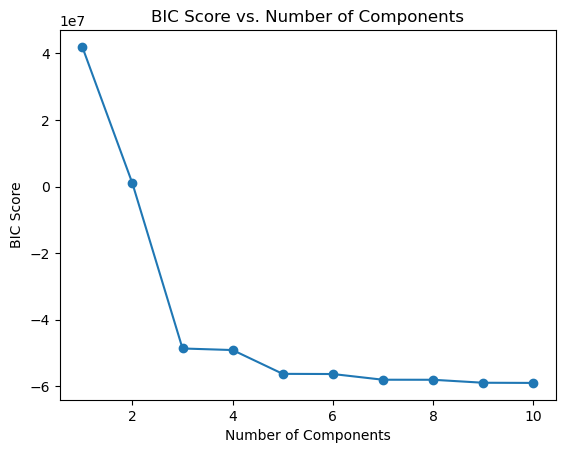

In [59]:
# Elbow Method

# Range of components to try
n_components_range = range(1, 11)

# Fit GMMs with different components and calculate the BIC (Bayesian Information Criterion)
bic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data_for_anomaly_detection_standardized)
    bic_scores.append(gmm.bic(data_for_anomaly_detection_standardized))

# Plot the BIC scores
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score vs. Number of Components')
plt.show()

It seems `n_component = 5` is good enough.

In [61]:
# # Sihouett Score

# from sklearn.metrics import silhouette_score

# # Range of components to try
# n_components_range = range(2, 11)

# # Calculate silhouette scores
# silhouette_scores = []
# for n_components in n_components_range:
#     gmm = GaussianMixture(n_components=n_components, random_state=42)
#     gmm.fit(data_for_anomaly_detection_standardized)
#     labels = gmm.predict(data_for_anomaly_detection_standardized)
#     silhouette_scores.append(silhouette_score(data_for_anomaly_detection_standardized, labels))

# # Plot silhouette scores
# plt.plot(n_components_range, silhouette_scores, marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score vs. Number of Components')
# plt.show()


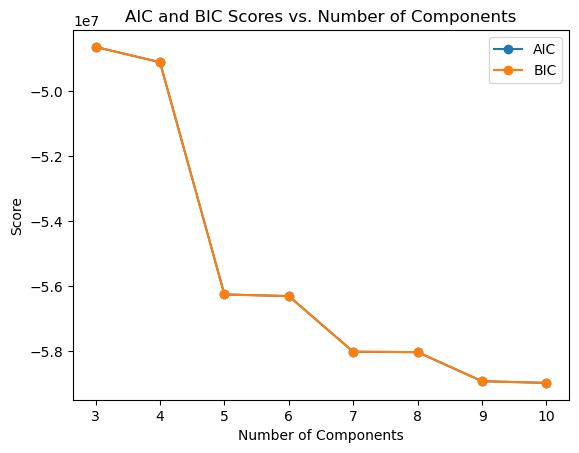

In [70]:
# AIC and BIC
n_components_range = range(3, 11)
# Calculate AIC and BIC scores
aic_scores = []
bic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data_for_anomaly_detection_standardized)
    aic_scores.append(gmm.aic(data_for_anomaly_detection_standardized))
    bic_scores.append(gmm.bic(data_for_anomaly_detection_standardized))

# Plot AIC and BIC scores
plt.plot(n_components_range, aic_scores, marker='o', label='AIC')
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('AIC and BIC Scores vs. Number of Components')
plt.legend()
plt.show()


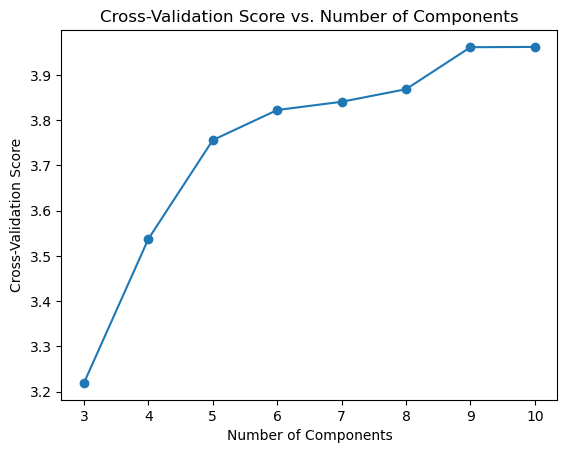

In [69]:
# Cross-validation

from sklearn.model_selection import cross_val_score


# Range of components to try
n_components_range = range(3, 11)

# Cross-validation scores
cv_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    scores = cross_val_score(gmm, data_for_anomaly_detection_standardized, cv=5)
    cv_scores.append(np.mean(scores))

# Plot cross-validation scores
plt.plot(n_components_range, cv_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Score vs. Number of Components')
plt.show()


### Choosing `threshold`

Choosing the threshold for anomaly detection is a critical step, and there is no one-size-fits-all answer. The optimal threshold depends on the characteristics of the data, the distribution of likelihood scores, and the specific requirements for balancing false positives and false negatives. Here are some approaches you can consider:

1. Visual Inspection: Visualize the distribution of likelihood scores and identify a threshold that clearly separates normal data from potential anomalies. Plot a histogram or kernel density estimate of the likelihood scores and look for a point where anomalies appear distinct.
2. Quantile-Based Threshold: Choose a threshold based on a certain quantile of the likelihood scores. For example, set the threshold at the 95th percentile to capture the top 5% of data points as anomalies.
3. Empirical Rule: If the likelihood scores follow a normal distribution, you might consider using the empirical rule (e.g., three standard deviations from the mean) to set a threshold.
4. ROC Curve (only if we have the labeled data) or Other Evaluation Metrics (precision, F1-score, ect.).

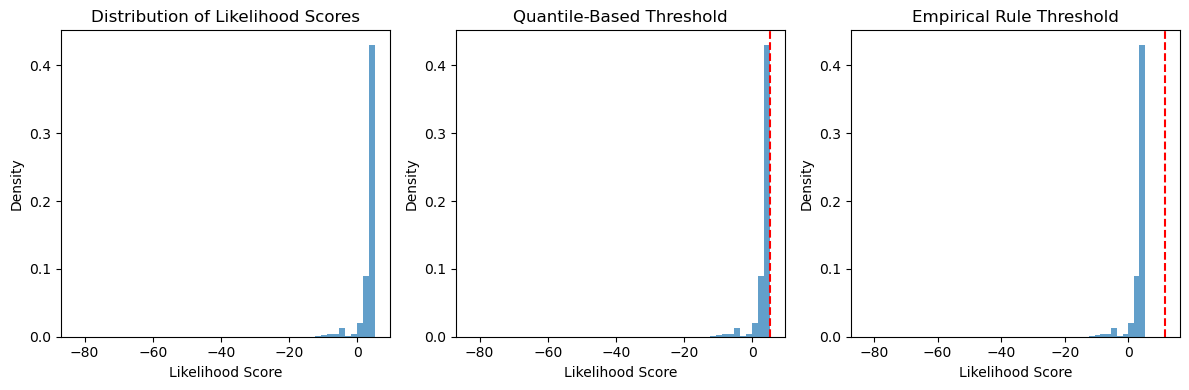

Quantile-Based Threshold: 5.19
Empirical Rule Threshold: 11.57


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Assuming you have a variable 'score' with the likelihood scores

# Visual Inspection
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(likelihoods, bins=50, density=True, alpha=0.7)
plt.xlabel('Likelihood Score')
plt.ylabel('Density')
plt.title('Distribution of Likelihood Scores')

# Quantile-Based Threshold (e.g., 95th percentile)
threshold_quantile = np.percentile(likelihoods, 95)
plt.subplot(1, 3, 2)
plt.hist(likelihoods, bins=50, density=True, alpha=0.7)
plt.axvline(x=threshold_quantile, color='red', linestyle='--', label='Threshold (95th percentile)')
plt.xlabel('Likelihood Score')
plt.ylabel('Density')
plt.title('Quantile-Based Threshold')

# Empirical Rule (e.g., three standard deviations from the mean)
mean_score = np.mean(likelihoods)
std_dev_score = np.std(likelihoods)
threshold_empirical = mean_score + 3 * std_dev_score
plt.subplot(1, 3, 3)
plt.hist(likelihoods, bins=50, density=True, alpha=0.7)
plt.axvline(x=threshold_empirical, color='red', linestyle='--', label='Threshold (3 std deviations)')
plt.xlabel('Likelihood Score')
plt.ylabel('Density')
plt.title('Empirical Rule Threshold')

plt.tight_layout()
plt.show()

# # ROC Curve and AUC (only if you have labeled data)
# # Assuming 'labels' is an array of true labels (0 for normal, 1 for anomaly)
# fpr, tpr, _ = roc_curve(labels, -score)  # Use -score for maximizing the area under the curve
# roc_auc = auc(fpr, tpr)

# # Precision-Recall Curve and AUC
# precision, recall, _ = precision_recall_curve(labels, -score)
# pr_auc = average_precision_score(labels, -score)

# plt.figure(figsize=(10, 4))

# plt.subplot(1, 2, 1)
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve')
# plt.legend(loc='lower right')

# plt.subplot(1, 2, 2)
# plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='upper right')

# plt.tight_layout()
# plt.show()

# Print or return the chosen thresholds
print(f"Quantile-Based Threshold: {threshold_quantile:.2f}")
print(f"Empirical Rule Threshold: {threshold_empirical:.2f}")


In [67]:
# # Visualize the distribution of likelihood scores
# plt.hist(likelihoods, bins=50, density=True, alpha=0.5)
# plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
# plt.xlabel('Likelihood Score')
# plt.ylabel('Density')
# plt.title('Distribution of Likelihood Scores')
# plt.legend()
# plt.show()


In [65]:
print(data.groupby('PRODUCT_CATEGORY_LEVEL1')['UNITS'].sum())
print(data.groupby('PRODUCT_CATEGORY_LEVEL1')['NET_SALES'].sum())

print(data.groupby('PRODUCT_MERCH_CLASSIFICATION3')['UNITS'].sum())
print(data.groupby('PRODUCT_MERCH_CLASSIFICATION3')['NET_SALES'].sum())


print(data.groupby(['PRODUCT_CATEGORY_LEVEL1', 'PRODUCT_MERCH_CLASSIFICATION3'])['UNITS'].sum())
print(data.groupby(['PRODUCT_CATEGORY_LEVEL1', 'PRODUCT_MERCH_CLASSIFICATION3'])['NET_SALES'].sum())



PRODUCT_CATEGORY_LEVEL1
Cat         7883940.0
Dog         1426748.0
Pharmacy    3891335.0
Name: UNITS, dtype: float64
PRODUCT_CATEGORY_LEVEL1
Cat         1.941596e+08
Dog         9.291127e+07
Pharmacy    5.830549e+06
Name: NET_SALES, dtype: float64
PRODUCT_MERCH_CLASSIFICATION3
Dry Food                      9191124.0
Flea Combs & Tick Removers      51592.0
Infection Care                3891335.0
Poop Scoopers                   13096.0
Test Kits                       54876.0
Name: UNITS, dtype: float64
PRODUCT_MERCH_CLASSIFICATION3
Dry Food                      2.806577e+08
Flea Combs & Tick Removers    2.110837e+05
Infection Care                5.830549e+06
Poop Scoopers                 2.838735e+05
Test Kits                     5.918219e+06
Name: NET_SALES, dtype: float64
PRODUCT_CATEGORY_LEVEL1  PRODUCT_MERCH_CLASSIFICATION3
Cat                      Dry Food                         7879747.0
                         Flea Combs & Tick Removers           500.0
                         

In [ ]:
# All product_part_numbers of MC3 == 'Dry Food'
id_list = data.loc[data['PRODUCT_MERCH_CLASSIFICATION3'] == 'Dry Food', 'PRODUCT_PART_NUMBER'].unique()

# Specify the number of IDs you want to randomly select
num_ids_to_select = 5

# Randomly select IDs
randomly_selected_ids = np.random.choice(id_list, size=num_ids_to_select, replace=False)

print(randomly_selected_ids)

[215371 133299 207634 160766 112845]


## 1. Time Series Analysis

- Visualize the time series of 'NET_SALES' and 'UNITS' over the given period
- Check for seasonality, trends, and unusual patterns

In [ ]:
# Convert 'ORDER_PLACED_DTTM' to datetime
data['ORDER_PLACED_DTTM'] = pd.to_datetime(data['ORDER_PLACED_DTTM'])

# Set 'ORDER_PLACED_DTTM' as the index for time series analysis
data.set_index('ORDER_PLACED_DTTM', inplace=True)

#### Population Level Time Series

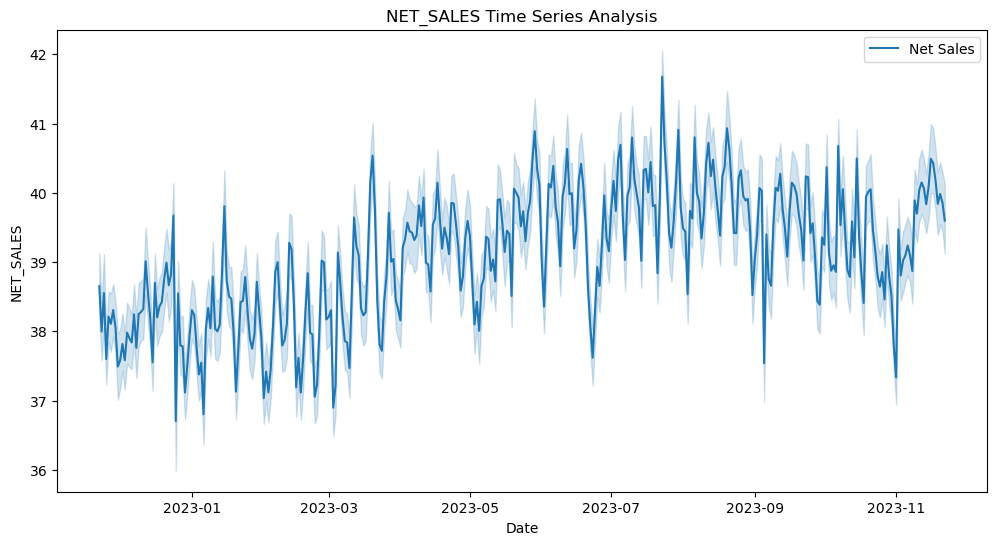

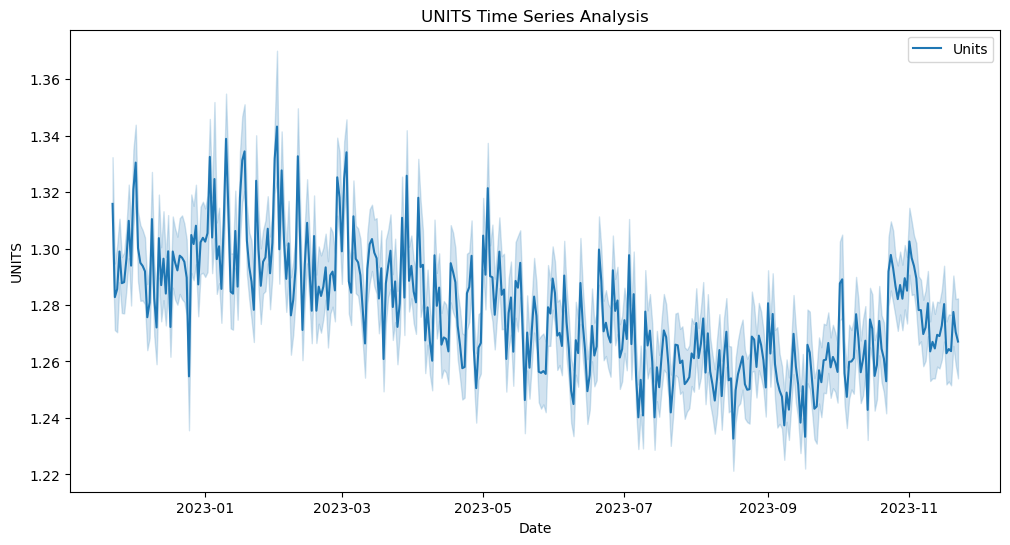

In [ ]:
# Population level

plt.figure(figsize=(12, 6))
sns.lineplot(data=data['NET_SALES'], label='Net Sales')
plt.title('NET_SALES Time Series Analysis')
plt.xlabel('Date')
plt.ylabel('NET_SALES')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=data['UNITS'], label='Units')
plt.title('UNITS Time Series Analysis')
plt.xlabel('Date')
plt.ylabel('UNITS')
plt.legend()
plt.show()


#### Segment the Data Based on PRODUCT_CATEGORY_LEVEL3 and PRODUCT_CATEGORY_LEVEL1

In [ ]:
segment_group_data = data.groupby(['ORDER_PLACED_DTTM', 'PRODUCT_CATEGORY_LEVEL1', 'PRODUCT_CATEGORY_LEVEL3'])[['NET_SALES', 'UNITS']].sum().reset_index()

# Convert 'ORDER_PLACED_DTTM' to datetime
segment_group_data['ORDER_PLACED_DTTM'] = pd.to_datetime(segment_group_data['ORDER_PLACED_DTTM'])

# Set 'ORDER_PLACED_DTTM' as the index for time series analysis
segment_group_data.set_index('ORDER_PLACED_DTTM', inplace=True)

# Combine 'PRODUCT_CATEGORY_LEVEL1' and 'PRODUCT_CATEGORY_LEVEL3' into a new column
segment_group_data['SEGMENT'] = segment_group_data['PRODUCT_CATEGORY_LEVEL1'] + ' - ' + segment_group_data['PRODUCT_CATEGORY_LEVEL3']

# Convert the index to datetime
segment_group_data.index = pd.to_datetime(segment_group_data.index)

# Only keep columns I need
segment_group_data = segment_group_data[['SEGMENT', 'NET_SALES', 'UNITS']]


In [ ]:

segment_group_data

,SEGMENT,NET_SALES,UNITS
ORDER_PLACED_DTTM,,,
2022-11-22,Cat - Dry Food,486078.63512,20578.0
2022-11-22,Dog - Dry Food,218262.93549,3400.0
2022-11-23,Cat - Dry Food,509859.80117,21350.0
2022-11-23,Dog - Dry Food,229408.28580,3608.0
2022-11-24,Cat - Dry Food,381931.05280,16073.0
...,...,...,...
2023-11-20,Dog - Dry Food,257486.98000,3728.0
2023-11-21,Cat - Dry Food,539491.04001,21317.0
2023-11-21,Dog - Dry Food,240616.33000,3545.0


In [ ]:
# # save data
# saved_segment_group_data = segment_group_data
# saved_segment_group_data_file_path = get_absolute_path(
#     'segment_group_data.csv',
#     'data/_small_set_sales_by_date_sku_zip',
#     PROJECT_BASE_DIR
# )

# saved_segment_group_data.to_csv(saved_segment_group_data_file_path)

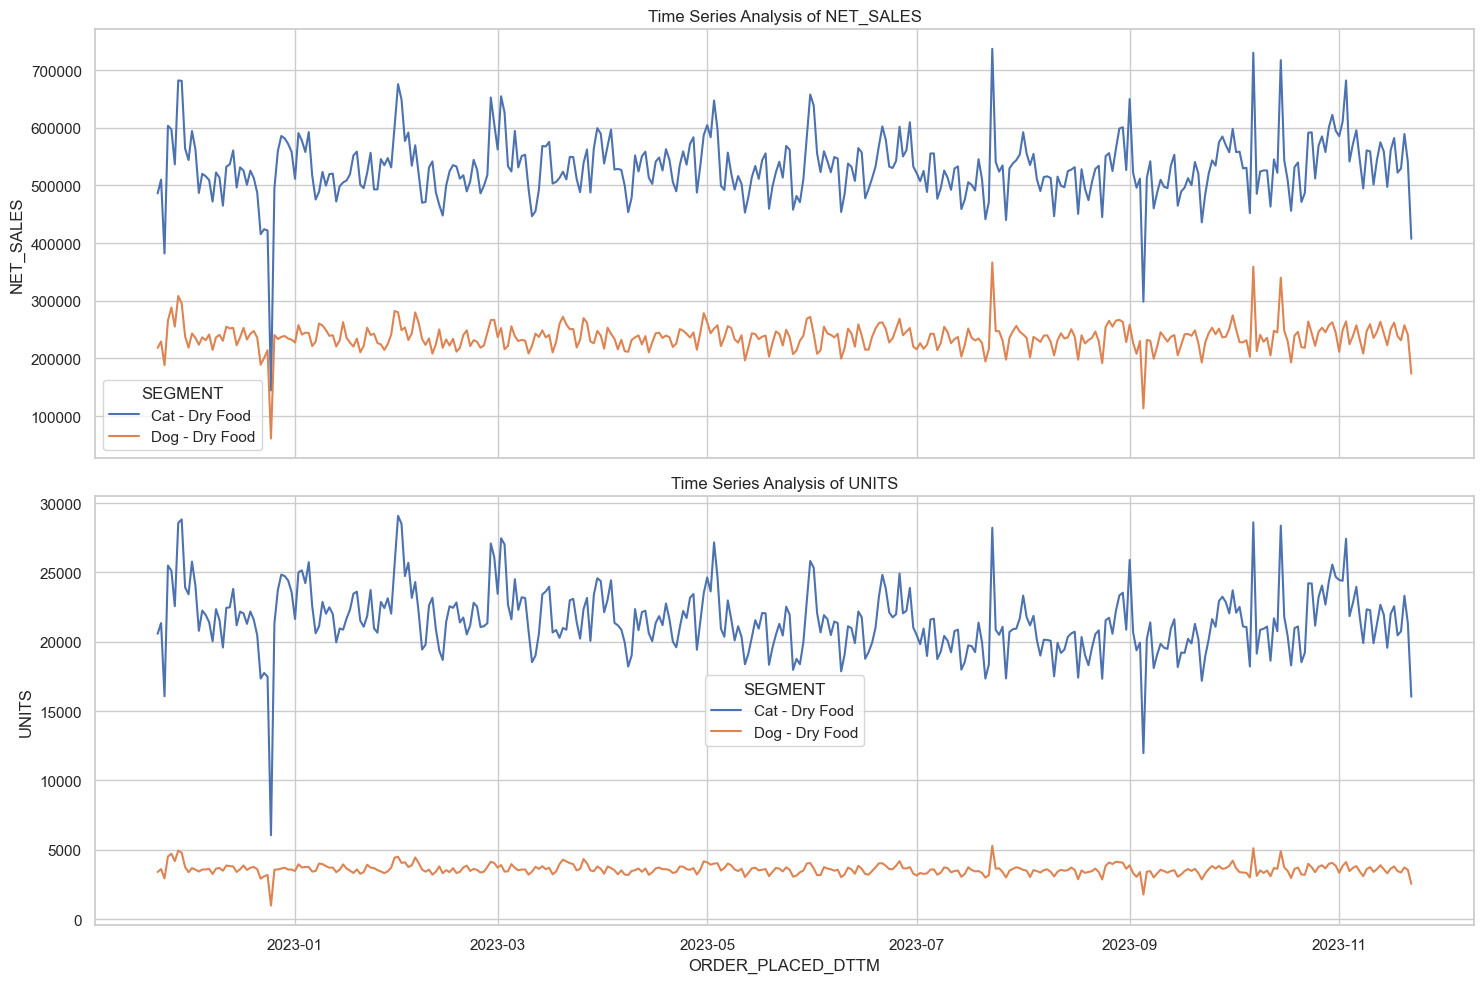

In [ ]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Plotting NET_SALES and UNITS in separate subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Time Series Analysis of NET_SALES
sns.lineplot(x=segment_group_data.index, y='NET_SALES', hue='SEGMENT', data=segment_group_data, ax=axes[0])
axes[0].set_title('Time Series Analysis of NET_SALES')
axes[0].set_ylabel('NET_SALES')

# Time Series Analysis of UNITS
sns.lineplot(x=segment_group_data.index, y='UNITS', hue='SEGMENT', data=segment_group_data, ax=axes[1])
axes[1].set_title('Time Series Analysis of UNITS')
axes[1].set_xlabel('ORDER_PLACED_DTTM')
axes[1].set_ylabel('UNITS')

# Adjust the layout for better visualization
plt.tight_layout()
plt.show()

Time series analysis over the `segment_group_data` for
- trends
- seasibaluty
- residuals

We want to perform the time series decomposition at each segment level, we should iterate through each segment and apply the decomposition separately. 


In [ ]:
# Initialize empty DataFrames to store results
trend_by_segment = pd.DataFrame()
seasonal_by_segment = pd.DataFrame()
residual_by_segment = pd.DataFrame()

# Add a small constant to avoid zero values for each segment
small_constant = 1e-6

# Iterate through each segment and perform time series decomposition
for _segment, _data in segment_group_data.groupby('SEGMENT'):
    net_sales = _data['NET_SALES'] + small_constant
    result = seasonal_decompose(net_sales, model='additive', period=7)
    
    trend_by_segment[_segment] = result.trend
    seasonal_by_segment[_segment] = result.seasonal
    residual_by_segment[_segment] = result.resid

In [ ]:
trend_by_segment

,Cat - Dry Food,Dog - Dry Food
ORDER_PLACED_DTTM,,
2022-11-22,NaN,NaN
2022-11-23,NaN,NaN
2022-11-24,NaN,NaN
2022-11-25,542388.847494,250435.324617
2022-11-26,570250.710458,261491.351375
...,...,...
2023-11-18,545744.846091,243396.930001
2023-11-19,532892.167148,236344.714287
2023-11-20,NaN,NaN


In [ ]:
seasonal_by_segment

,Cat - Dry Food,Dog - Dry Food
ORDER_PLACED_DTTM,,
2022-11-22,671.444855,1771.310539
2022-11-23,15214.872004,-1080.501460
2022-11-24,10562.702905,-3860.780976
2022-11-25,-9514.127007,-13128.145483
2022-11-26,-19342.344587,-4390.317990
...,...,...
2023-11-18,-19342.344587,-4390.317990
2023-11-19,-10801.977171,8888.007536
2023-11-20,13209.429002,11800.427835


In [ ]:
residual_by_segment

,Cat - Dry Food,Dog - Dry Food
ORDER_PLACED_DTTM,,
2022-11-22,NaN,NaN
2022-11-23,NaN,NaN
2022-11-24,NaN,NaN
2022-11-25,70480.426534,28284.908667
2022-11-26,46258.543010,31137.812626
...,...,...
2023-11-18,-4335.611493,-546.642010
2023-11-19,7114.160024,-13748.231821
2023-11-20,NaN,NaN


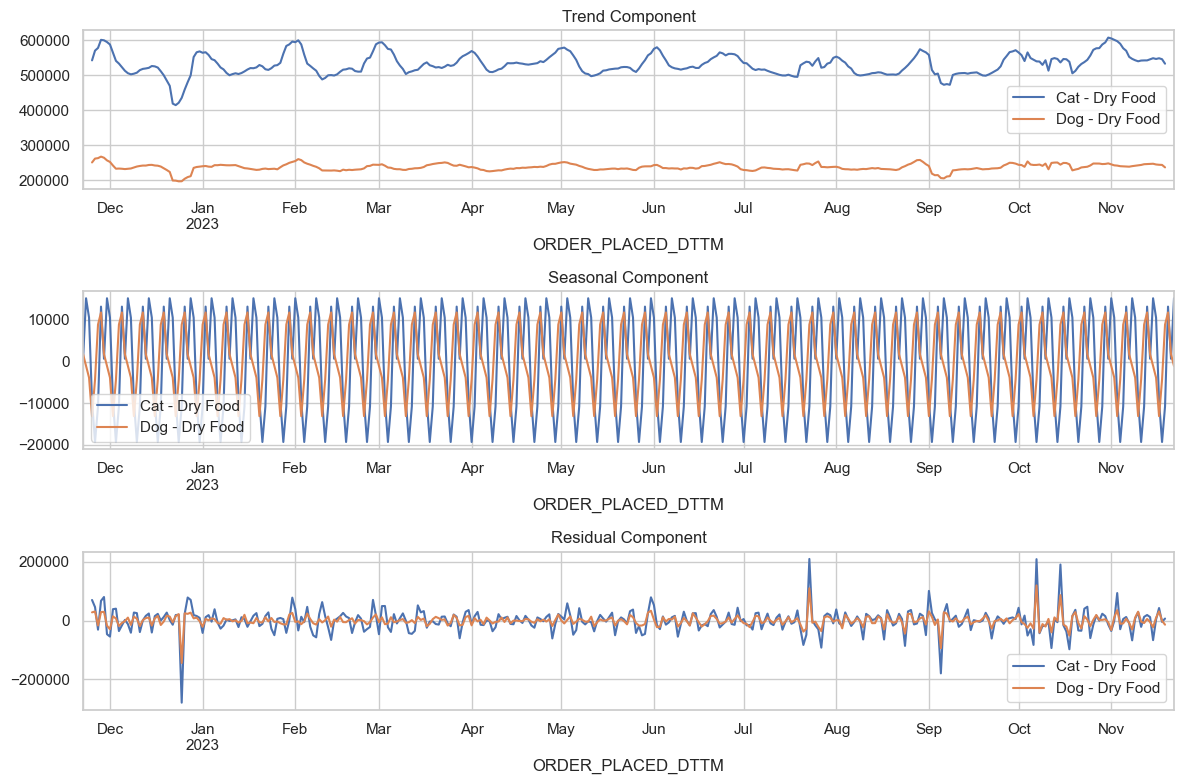

In [ ]:
# Plot the decomposed components for all segments
plt.figure(figsize=(12, 8))

# Plot trend for all segments
plt.subplot(3, 1, 1)
trend_by_segment.plot(ax=plt.gca())
plt.title('Trend Component')

# Plot seasonal for all segments
plt.subplot(3, 1, 2)
seasonal_by_segment.plot(ax=plt.gca())
plt.title('Seasonal Component')

# Plot residual for all segments
plt.subplot(3, 1, 3)
residual_by_segment.plot(ax=plt.gca())
plt.title('Residual Component')

plt.tight_layout()
plt.show()

#### Generate a Subset DataFrame for Randomly Selected IDs

In [ ]:
subset_data = data[data['PRODUCT_PART_NUMBER'].isin(randomly_selected_ids)][['PRODUCT_PART_NUMBER', 'NET_SALES', 'UNITS']]


In [ ]:
subset_data.PRODUCT_PART_NUMBER.unique()

array([112845, 133299, 160766, 207634, 215371])

In [ ]:
subset_data.head(3)

,PRODUCT_PART_NUMBER,NET_SALES,UNITS
ORDER_PLACED_DTTM,,,
2022-11-22,112845,0.00,1.0
2022-11-22,112845,38.96,2.0
2022-11-22,112845,74.81,4.0


In [ ]:
# save data
saved_subset_data = subset_data
saved_subset_data_file_path = get_absolute_path(
    'subset_data.csv',
    'data/_small_set_sales_by_date_sku_zip',
    PROJECT_BASE_DIR
)

saved_subset_data.to_csv(saved_subset_data_file_path)

In [ ]:
# Choose the threshold at the 95th percentile
threshold = np.percentile(likelihoods, 95)


In [ ]:
# Choose the threshold based on the empirical rule
mean_likelihood = np.mean(likelihoods)
std_dev_likelihood = np.std(likelihoods)
threshold = mean_likelihood - 3 * std_dev_likelihood
